In [1]:
import numpy as np
from collections import defaultdict
from typing import List, Set, Dict, Tuple, Optional
import matplotlib.pyplot as plt

In [2]:
class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None
        
    def fit(self, X: np.ndarray) -> 'StandardScaler':
        """Compute the mean and standard deviation of the input data."""
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0, ddof=1)
        return self
        
    def transform(self, X: np.ndarray) -> np.ndarray:
        """Standardize the input data using pre-computed mean and std."""
        return (X - self.mean_) / self.scale_
        
    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        """Fit to data, then transform it."""
        return self.fit(X).transform(X)

def compute_distance(x1: np.ndarray, x2: np.ndarray, metric: str = 'euclidean') -> float:
    """
    Compute distance between two points using specified metric.
    
    Args:
        x1, x2: Points to compare
        metric: Distance metric ('euclidean' or 'manhattan')
    """
    if metric == 'euclidean':
        return np.linalg.norm(x1 - x2)
    elif metric == 'manhattan':
        return np.sum(np.abs(x1 - x2))
    else:
        raise ValueError(f"Unknown metric: {metric}")

In [3]:
class DBSCAN:
    def __init__(self, eps: float = 0.3, min_points: int = 4, metric: str = 'euclidean'):
        """
        Initialize DBSCAN algorithm.
        
        Args:
            eps: Maximum distance between points to be considered neighbors
            min_points: Minimum points required to form a dense region
            metric: Distance metric to use
        """
        self.eps = eps
        self.min_points = min_points
        self.metric = metric
        self.labels_ = None
        
    def fit(self, X: np.ndarray) -> 'DBSCAN':
        """Perform DBSCAN clustering."""
        n_samples = X.shape[0]
        self.labels_ = np.full(n_samples, -1)
        
        neighbors = self._find_neighbors(X)
        core_points = self._find_core_points(neighbors)
        
        current_cluster = 0
        for point_idx in range(n_samples):
            if self.labels_[point_idx] != -1 or point_idx not in core_points:
                continue
                
            self.labels_[point_idx] = current_cluster
            self._expand_cluster(point_idx, neighbors, core_points, current_cluster)
            current_cluster += 1
            
        return self
    
    def _find_neighbors(self, X: np.ndarray) -> Dict[int, Set[int]]:
        """Find neighbors for each point within eps distance."""
        neighbors = defaultdict(set)
        n_samples = X.shape[0]
        
        for i in range(n_samples):
            for j in range(i + 1, n_samples):
                if compute_distance(X[i], X[j], self.metric) <= self.eps:
                    neighbors[i].add(j)
                    neighbors[j].add(i)
                    
        return neighbors
    
    def _find_core_points(self, neighbors: Dict[int, Set[int]]) -> Set[int]:
        """Identify core points based on number of neighbors."""
        return {
            point_idx 
            for point_idx, point_neighbors in neighbors.items()
            if len(point_neighbors) >= self.min_points - 1
        }
    
    def _expand_cluster(self, point_idx: int, neighbors: Dict[int, Set[int]],
                       core_points: Set[int], cluster_label: int) -> None:
        """Expand cluster from a core point to its neighbors."""
        queue = list(neighbors[point_idx])
        
        while queue:
            neighbor_idx = queue.pop(0)
            
            if self.labels_[neighbor_idx] != -1:
                continue
                
            self.labels_[neighbor_idx] = cluster_label
            
            if neighbor_idx in core_points:
                new_neighbors = neighbors[neighbor_idx]
                queue.extend([
                    idx for idx in new_neighbors 
                    if self.labels_[idx] == -1
                ])

    def fit_predict(self, X: np.ndarray) -> np.ndarray:
        """Perform clustering and return cluster labels."""
        self.fit(X)
        return self.labels_

In [4]:
def generate_spiral(n_points: int, start_radius: float, noise: float = 0.2) -> np.ndarray:
    """Generate a spiral-shaped cluster."""
    t = np.linspace(0, 2*np.pi, n_points)
    r = start_radius + t
    x = r * np.cos(t*2)
    y = r * np.sin(t*2)
    x += np.random.normal(0, noise, n_points)
    y += np.random.normal(0, noise, n_points)
    return np.column_stack([x, y])

def generate_dataset(noise_level: float = 0.2) -> np.ndarray:
    """Generate dataset with spirals, gaussian clusters, and noise."""
    np.random.seed(42)
    
    spiral1 = generate_spiral(100, 0, noise_level)
    spiral2 = generate_spiral(100, 0, noise_level) + [5, 5]
    
    gaussian1 = np.random.normal(2, 0.5, (150, 2)) + np.random.normal(0, noise_level, (150, 2))
    gaussian2 = np.random.normal(4, 1.2, (100, 2)) + np.random.normal(0, noise_level, (100, 2))
    gaussian3 = np.random.normal([0, 5], [0.7, 0.7], (80, 2)) + np.random.normal(0, noise_level, (80, 2))
    
    noise = np.random.uniform(-2, 8, (50, 2))
    
    return np.vstack([spiral1, spiral2, gaussian1, gaussian2, gaussian3, noise])

Number of clusters: 4
Number of noise points: 37


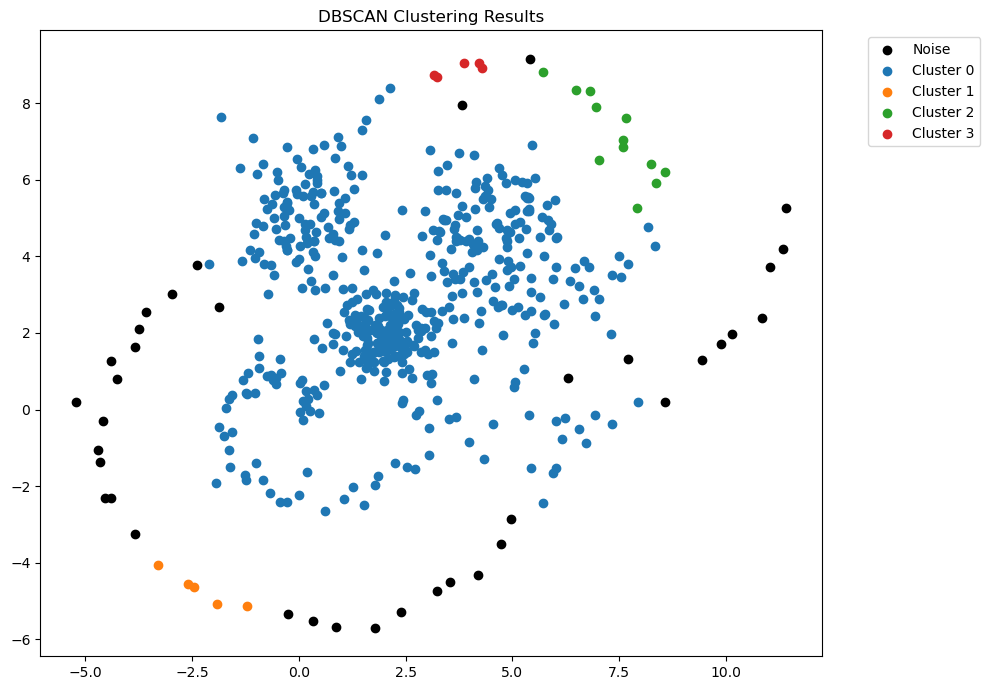

In [5]:
def main():
    X = generate_dataset(noise_level=0.2)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    dbscan = DBSCAN(eps=0.35, min_points=4, metric='euclidean')
    labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")
    
    plt.figure(figsize=(10, 7))
    plt.scatter(X[labels == -1][:, 0], X[labels == -1][:, 1], 
                  c='black', label='Noise')
       
    for label in set(labels) - {-1}:
           plt.scatter(X[labels == label][:, 0], X[labels == label][:, 1], 
                   label=f'Cluster {label}')
            
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('DBSCAN Clustering Results')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()